# 감정분석 모델 생성

# Step 1. 데이터 수집
## 1-1. csv파일로 데이터 불러오기

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('data_ori.csv')
df

,문장,감정
0,"어, 청소 니가 대신 해 줘!",Neutral
1,둘 다 청소 하기 싫어. 귀찮아.,Neutral
2,둘 다 하기 싫어서 화내.,Angry
3,그럼 방세는 어떡해.,Sadness
4,권태긴줄 알았는데 다른 사람이 생겼나보더라고.,Sadness
...,...,...
43986,나 엘리베이터에 갇혔어.,happiness
43987,하지만 기분이 나쁜 걸 어떡해?,sadness
43988,자취방 엘리베이턴데 정전인가봐.,sadness
43989,나 드디어 프로젝트 끝났어!,disgust


In [5]:
df.loc[:, '감정'] = df['감정'].str.lower()
unique_count = df['감정'].unique()
print(unique_count)

['neutral' 'angry' 'sadness' 'disgust' 'surprise' 'fear' 'happiness']


In [6]:
df = df[df['감정'] != 'neutral']
unique_count = df['감정'].unique()
print(unique_count)

['angry' 'sadness' 'disgust' 'surprise' 'fear' 'happiness']


In [7]:
import pandas as pd
df_copy = df.copy()

#감정을 숫자로 매칭
df_copy.loc[(df_copy['감정'] == "angry"), '감정'] = 0
df_copy.loc[(df_copy['감정'] == "disgust"), '감정'] = 0
df_copy.loc[(df_copy['감정'] == "sadness"), '감정'] = 1
df_copy.loc[(df_copy['감정'] == "fear"), '감정'] = 2
df_copy.loc[(df_copy['감정'] == "surprise"), '감정'] = 2
df_copy.loc[(df_copy['감정'] == "happiness"), '감정'] = 3

# 원래 df에 다시 넣어주고, 맨 왼쪽의 인덱스를 초기화해줌
df.loc[:, '감정'] = df_copy['감정']
df.reset_index(drop=True, inplace=True)

In [8]:
label_count = df['감정'].value_counts()
print(label_count)

감정
1    13415
0    10080
2     5029
3     3509
Name: count, dtype: int64


In [28]:
data_list = []
target_list = []

for q,  label in zip(df['문장'], df['감정']):
    data_list.append(q)
    target_list.append(label)

from collections import Counter
import numpy as np

# all_target_num에서 각 클래스별 개수 확인
class_counts = Counter(target_list)

# 가장 적은 데이터 수를 가진 클래스의 수
min_samples = min(class_counts.values())

# 새로운 데이터와 타겟을 저장할 리스트
distribute_data = []
distribute_target = []

np.random.seed(42)

# 각 클래스에서 가장 적은 샘플 수만큼 데이터를 선택하여 저장
for target_class in set(target_list):
    class_indices = [i for i, c in enumerate(target_list) if c == target_class]
    selected_indices = np.random.choice(class_indices, min_samples, replace=False)
    distribute_data.extend([data_list[i] for i in selected_indices])
    distribute_target.extend([target_list[i] for i in selected_indices])

# 리스트를 numpy 배열로 변환
distribute_data = np.array(distribute_data)
new_all_target_num = np.array(distribute_target)

# 클래스별로 데이터 수 확인 (새로 조절한 데이터로 확인)
distribute_class_counts = Counter(distribute_target)

# 결과 출력
print("새로 조절한 클래스별 갯수:")
for emotion, count in distribute_class_counts.items():
    print(f"{emotion}: {count}개")

새로 조절한 클래스별 갯수:
0: 3509개
1: 3509개
2: 3509개
3: 3509개


In [29]:
from konlpy.tag import Kkma

kkma = Kkma()

tokenized_data = []

for s in distribute_data:
    text_2 = [word for word, pos in kkma.pos(s) if (pos == 'NNG') or (pos == 'VV') or (pos == 'NP') or (pos == 'VA') or (pos == 'MAG')] # 조사 또는 문장부호는 빼줌
    #if text_2:  # 빈 리스트가 아닌 경우에만 추가
    tokenized_data.append(text_2)

In [30]:
print(kkma.pos(distribute_data[0]))
print(distribute_data[0])
print(tokenized_data[0])
print(distribute_target[0])

[('응', 'UN'), ('.', 'SF'), ('쓰레기', 'NNG'), ('는', 'JX'), ('버리', 'VV'), ('ㄴ다', 'ECS'), ('치', 'VV'), ('어도', 'ECD'), ('쓰레기통', 'NNG'), ('에서', 'JKM'), ('냄새', 'NNG'), ('가', 'JKS'), ('안', 'MAG'), ('빠지', 'VV'), ('어', 'ECS'), ('.', 'SF')]
응. 쓰레기는 버린다쳐도 쓰레기통에서 냄새가 안 빠져.
['쓰레기', '버리', '치', '쓰레기통', '냄새', '안', '빠지']
0


In [31]:
from collections import Counter

# 전체 데이터에 대한 단어 빈도수 계산
word_counts = Counter(word for sentence in tokenized_data for word in sentence)

# 빈도수에 따라 단어를 정렬
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 단어로 단어 사전 만들기
top_words = [word for word, count in sorted_words[:500]]
word_to_index = {word: idx for idx, word in enumerate(top_words)}

# 모든 데이터를 숫자로 변환
num_tokenized_data = [[word_to_index.get(word, 0) for word in sentence] for sentence in tokenized_data]

In [32]:
print(word_to_index)

{'나': 0, '하': 1, '너무': 2, '되': 3, '안': 4, '없': 5, '좋': 6, '있': 7, '같': 8, '오': 9, '알': 10, '친구': 11, '정말': 12, '보': 13, '그리하': 14, '고맙': 15, '일': 16, '그러': 17, '또': 18, '어제': 19, '진짜': 20, '힘들': 21, '지금': 22, '사람': 23, '기분': 24, '무섭': 25, '가': 26, '내': 27, '집': 28, '다': 29, '많이': 30, '약속': 31, '어': 32, '당첨': 33, '해피': 34, '좀': 35, '놀라': 36, '못': 37, '듣': 38, '아': 39, '먹': 40, '내가': 41, '끝나': 42, '아직': 43, '회사': 44, '다치': 45, '엄청': 46, '생각': 47, '이벤트': 48, '청소': 49, '그렇': 50, '괜찮': 51, '마음': 52, '갑자기': 53, '시간': 54, '때': 55, '잘': 56, '화장실': 57, '모르': 58, '오늘': 59, '프로젝트': 60, '맞': 61, '나오': 62, '드디어': 63, '갇히': 64, '같애': 65, '받': 66, '우리': 67, '어떻': 68, '말': 69, '만나': 70, '깜짝': 71, '떨어지': 72, '그냥': 73, '요즘': 74, '지진': 75, '걱정': 76, '그': 77, '나가': 78, '축하': 79, '연락': 80, '저녁': 81, '이제': 82, '않': 83, '곰팡이': 84, '술': 85, '많': 86, '뭐': 87, '싸우': 88, '전화': 89, '치우': 90, '왜': 91, '자': 92, '마라톤': 93, '냄새': 94, '산책': 95, '헤어지': 96, '달': 97, '근데': 98, '동안': 99, '아빠': 100, '기다리': 101, '생기': 102, 

In [33]:
# 상위 500개의 단어 선택
top_words = [word for word, count in word_counts.most_common(500)]

# 상위 500개의 단어에 대한 빈도수 출력
for word in top_words:
    print(f'{word}: {word_counts[word]}번')

나: 3310번
하: 2515번
너무: 2010번
되: 1532번
안: 1436번
없: 1220번
좋: 1220번
있: 1189번
같: 984번
오: 795번
알: 787번
친구: 723번
정말: 716번
보: 716번
그리하: 649번
고맙: 627번
일: 623번
그러: 621번
또: 621번
어제: 613번
진짜: 606번
힘들: 588번
지금: 575번
사람: 568번
기분: 568번
무섭: 556번
가: 534번
내: 533번
집: 521번
다: 520번
많이: 502번
약속: 477번
어: 456번
당첨: 451번
해피: 434번
좀: 432번
놀라: 429번
못: 417번
듣: 412번
아: 411번
먹: 405번
내가: 403번
끝나: 401번
아직: 400번
회사: 400번
다치: 394번
엄청: 381번
생각: 378번
이벤트: 373번
청소: 359번
그렇: 352번
괜찮: 336번
마음: 335번
갑자기: 333번
시간: 329번
때: 326번
잘: 320번
화장실: 312번
모르: 312번
오늘: 311번
프로젝트: 305번
맞: 299번
나오: 298번
드디어: 287번
갇히: 281번
같애: 280번
받: 272번
우리: 271번
어떻: 270번
말: 264번
만나: 263번
깜짝: 260번
떨어지: 259번
그냥: 251번
요즘: 250번
지진: 248번
걱정: 246번
그: 245번
나가: 243번
축하: 241번
연락: 240번
저녁: 239번
이제: 238번
않: 234번
곰팡이: 233번
술: 231번
많: 231번
뭐: 225번
싸우: 221번
전화: 216번
치우: 214번
왜: 211번
자: 211번
마라톤: 209번
냄새: 206번
산책: 206번
헤어지: 205번
달: 205번
근데: 205번
동안: 204번
아빠: 203번
기다리: 202번
생기: 199번
이번: 198번
크: 198번
기록: 198번
밥: 196번
계속: 195번
너: 194번
아까: 193번
얼마나: 192번
얘기: 191번
다시: 190번
혼

In [15]:
print(num_tokenized_data[0:10])
print(distribute_target[0:10])

[[26, 451, 28, 134, 0], [30, 7, 10, 88, 38, 4, 9], [0, 153, 195, 4, 18, 0, 63], [0, 178, 169, 139, 290], [66, 25, 280, 7, 12, 72, 37, 341, 60, 280, 12, 430, 0], [342, 482, 5, 286], [207, 270, 131, 0], [129, 1, 0, 8, 52, 291, 0, 2, 163, 0, 142], [370, 189, 4, 0, 12, 14, 179, 170, 14, 0], [29, 0, 0, 10, 371, 344, 225, 176, 64]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
import numpy as np
lengths = np.array([len(x) for x in num_tokenized_data])
print(np.mean(lengths), np.median(lengths))

6.481761185522941 6.0


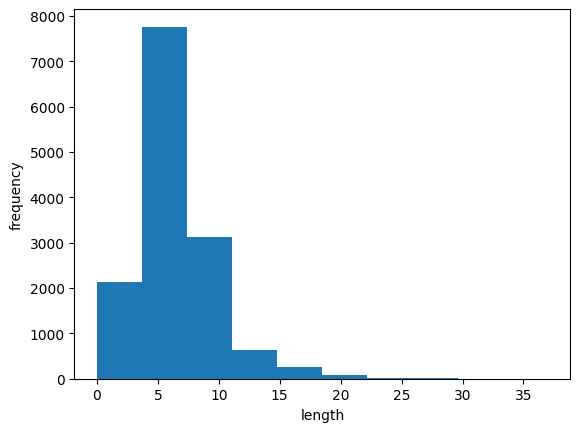

In [17]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel("length")
plt.ylabel("frequency")
plt.show()

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(num_tokenized_data, maxlen = 7)

print(train_seq.shape)


(14036, 7)


In [17]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(train_seq, distribute_target, test_size = 0.2, random_state = 42)

In [18]:
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state = 42)

In [19]:
train_target = np.array(train_target)
val_target = np.array(val_target)
test_target = np.array(test_target)

print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

print(train_target.shape)
print(val_target.shape)
print(test_target.shape)

(8982, 7)
(2246, 7)
(2808, 7)
(8982,)
(2246,)
(2808,)


# Step 2. 모델

## 2-1. 모델 학습

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# 모델 정의
model = Sequential()
model.add(Embedding(input_dim=500, output_dim=128, input_length=7))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax')) # 클래스의 개수에 맞게 설정


initial_learning_rate = 0.005
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=10000, decay_rate=0.9)

optimizer = SGD(learning_rate=lr_schedule)

# 모델 컴파일
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 콜백 정의
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

# 모델 학습
history = model.fit(train_input, train_target, epochs=300, batch_size=64,
                    validation_data=(val_input, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/300
141/141 [==============================] - 7s 21ms/step - loss: 1.5480 - accuracy: 0.3546 - val_loss: 1.3865 - val_accuracy: 0.2346
Epoch 2/300
141/141 [==============================] - 2s 14ms/step - loss: 1.2867 - accuracy: 0.4290 - val_loss: 1.3367 - val_accuracy: 0.3246
Epoch 3/300
141/141 [==============================] - 2s 14ms/step - loss: 1.1983 - accuracy: 0.4715 - val_loss: 1.2370 - val_accuracy: 0.4653
Epoch 4/300
141/141 [==============================] - 2s 14ms/step - loss: 1.1360 - accuracy: 0.5031 - val_loss: 1.0918 - val_accuracy: 0.5516
Epoch 5/300
141/141 [==============================] - 2s 13ms/step - loss: 1.0975 - accuracy: 0.5184 - val_loss: 1.0103 - val_accuracy: 0.5801
Epoch 6/300
141/141 [==============================] - 2s 14ms/step - loss: 1.0817 - accuracy: 0.5356 - val_loss: 0.9541 - val_accuracy: 0.6073
Epoch 7/300
141/141 [==============================] - 2s 14ms/step - loss: 1.0484 - accuracy: 0.5598 - val_loss: 0.9277 - val_accuracy:

## 2-2. 모델 평가

In [53]:
# 패딩이 완료된 테스트 데이터
test_input = pad_sequences(test_input, maxlen=8)

loss, accuracy = model.evaluate(test_input, test_target)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

88/88 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.7432
Test Loss: 0.6898108720779419
Test Accuracy: 0.7432336211204529


# STEP 3. 문장에서 감정분석 하기

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from konlpy.tag import Kkma

# Assuming 'model' and 'word_to_index' are defined before this code

# Load the Kkma tokenizer
kkma = Kkma()

def tokenize_and_pad(sentence, tokenizer, word_to_index, max_length=7):
    input_tokens = [word for word, pos in tokenizer.pos(sentence) if (pos == 'NNG') or (pos == 'VV') or (pos == 'NP') or (pos == 'VA') or (pos == 'MAG')]
    input_indices = [word_to_index.get(word, 0) for word in input_tokens]
    padded_input = pad_sequences([input_indices], maxlen=max_length)
    return padded_input

# 사용 예시
while True:
    input_sentence = input()
    if input_sentence == '0':
        break

    padded_input = tokenize_and_pad(input_sentence, kkma, word_to_index)

    predicted_probabilities = model.predict(padded_input)
    predicted_class = np.argmax(predicted_probabilities)

    emotions = ['분노', '슬픔', '불안', '기쁨']
    predicted_emotion = emotions[predicted_class]

    print(f"입력 문장: {input_sentence}")
    print(f"예측된 감정: {predicted_emotion}")
    print(f"각 클래스의 확률: {predicted_probabilities[0]}")


1/1 [==============================] - 1s 1s/step
입력 문장: 친구랑 싸워서 기분이 너무 안좋아
예측된 감정: 슬픔
각 클래스의 확률: [0.41163877 0.4180796  0.12715481 0.04312674]


In [71]:
model.save('C:\\Users\\kikikiju\\Desktop\\saved_model\\12-10-model.pt')

INFO:tensorflow:Assets written to: C:\Users\kikikiju\Desktop\saved_model\12-10-model.pt\assets


INFO:tensorflow:Assets written to: C:\Users\kikikiju\Desktop\saved_model\12-10-model.pt\assets


# Plus. 모델 로드 후 감정분석을 통해 음악 플레이리스트 추천해주기

In [22]:
import tensorflow as tf
model2 = tf.keras.models.load_model('C:\\Users\\kikikiju\\Desktop\\saved_model\\12-10-model.pt')

In [1]:
import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from konlpy.tag import Kkma


# Load the Kkma tokenizer
kkma = Kkma()

def tokenize_and_pad(sentence, tokenizer, word_to_index, max_length=7):
    input_tokens = [word for word, pos in tokenizer.pos(sentence) if (pos == 'NNG') or (pos == 'VV') or (pos == 'NP') or (pos == 'VA') or (pos == 'MAG')]
    input_indices = [word_to_index.get(word, 0) for word in input_tokens]
    padded_input = pad_sequences([input_indices], maxlen=max_length)
    return padded_input

input_sentence = input()

padded_input = tokenize_and_pad(input_sentence, kkma, word_to_index)
predicted_probabilities = model2.predict(padded_input)
predicted_class = np.argmax(predicted_probabilities)

emotions = ['분노', '슬픔', '불안', '기쁨']
predicted_emotion = emotions[predicted_class]

print(f"입력 문장: {input_sentence}")
print(f"예측된 감정: {predicted_emotion}")
print(f"각 클래스의 확률: {predicted_probabilities[0]}")

NameError: name 'word_to_index' is not defined

In [39]:
import os
from googleapiclient.discovery import build

def search_youtube(api_key, query, max_results=5):
    youtube = build('youtube', 'v3', developerKey=api_key)

    # 검색 실행
    search_response = youtube.search().list(
        q=query,
        type='video',
        part='id,snippet',
        maxResults=max_results
    ).execute()

    # 결과에서 동영상의 ID 추출
    video_ids = [item['id']['videoId'] for item in search_response['items']]

    # 각 동영상의 주소 생성
    video_urls = [f'https://www.youtube.com/watch?v={video_id}' for video_id in video_ids]

    return video_urls

if __name__ == "__main__":
    # YouTube API 키를 설정
    youtube_api_key = ""

    # 검색어를 입력
    if(predicted_emotion == "분노"):
        print(predicted_emotion)
        search_query = "화날 때 듣기 좋은 음악"
    elif(predicted_emotion == "슬픔"):
        print(predicted_emotion)
        search_query = "슬플 때 듣기 좋은 음악"
    elif(predicted_emotion == "불안"):
        print(predicted_emotion)        
        search_query =  "불안할 때 듣기 좋은 음악"
    elif(predicted_emotion == "기쁨"):
        print(predicted_emotion)
        search_query = "기쁠 때 듣기 좋은 음악"
    
    print(search_query)

    # YouTube API를 사용하여 동영상 주소 가져오기
    video_urls = search_youtube(youtube_api_key, search_query)

    # 결과 출력
    print(f"\n상위 5개 동영상 주소:")
    for i, video_url in enumerate(video_urls, start=1):
        print(f"{i}. {video_url}")


분노
화날 때 듣기 좋은 음악

상위 5개 동영상 주소:
1. https://www.youtube.com/watch?v=6atvmgoKKNQ
2. https://www.youtube.com/watch?v=71hZutqP_cM
3. https://www.youtube.com/watch?v=8yC_fnORfwU
4. https://www.youtube.com/watch?v=mEKAXv6gSgw
5. https://www.youtube.com/watch?v=RtPwBk0pqKE
